In [ ]:
import dask

dask.config.set({"dataframe.query-planning": False})

import numpy as np
from pathlib import Path
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
import _utils

cfg = readwrite.config()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error a

## Compute metrics

In [ ]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from scib_metrics.benchmark._core import _LABELS #, _BATCH, _METRIC_TYPE

xenium_cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])

# Set up argument parser
# Access the arguments
segmentation = 'proseg_expected'
condition = 'breast'
panel = 'breast'
normalisation_method = "lognorm"  # fix this for now, even for sctransfrom args.normalisation_method
layer = 'data'
n_comps = 50

k = (segmentation,condition,panel,normalisation_method)
name = '/'.join(k)

panel = Path(f'/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/std_seurat_analysis/{segmentation}/{condition}/{panel}')
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2'

segmentation = panel.parents[1].stem
condition = panel.parents[0].stem

# variables
OBSM_KEY = 'X_pca'
BATCH_KEY = 'blobs'
CT_KEY = ('matched_reference_combo', 'rctd_class_unaware', 'Level2')
exclude_cell_type_containing = 'malignant'

# read xenium samples
ads = {}
for donor in (donors := panel.iterdir()):
    for sample in (samples := donor.iterdir()):
        k = (
            segmentation,
            condition,
            panel.stem,
            donor.stem,
            sample.stem,
            normalisation_method,
        )
        name = "/".join(k)

        sample_counts_path = sample / f"{normalisation_method}/normalised_counts/{layer}.parquet"
        sample_idx_path = sample / f"{normalisation_method}/normalised_counts/cells.parquet"

        ads[k] = sc.AnnData(pd.read_parquet(sample_counts_path))
        if layer != "scale_data":  # no need to sparsify scale_data which is dense
            ads[k].X = scipy.sparse.csr_matrix(ads[k].X)
        ads[k].obs_names = pd.read_parquet(sample_idx_path).iloc[:, 0]

        sample_annotation_dir = xenium_cell_type_annotation_dir / f'{name}/reference_based'
        for reference in (references := sample_annotation_dir.iterdir()):
            for method in (methods := reference.iterdir()):
                for level in (levels := method.iterdir()):

                    annot_file = sample_annotation_dir / f"{reference.stem}/{method.stem}/{level.stem}/single_cell/labels.parquet"
                    ads[k].obs[(reference.stem, method.stem, level.stem)] = pd.read_parquet(annot_file).set_index("cell_id").iloc[:, 0]


# concatenate
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample"]
for k in ads.keys():
    for i, lvl in enumerate(xenium_levels):
        ads[k].obs[lvl] = k[i]
ad_merge = sc.concat(ads)
ad_merge.obs[BATCH_KEY] = ad_merge.obs[xenium_levels].agg("_".join,axis=1)

# remove NaN  and exclude_cell_type_containing annotations
# ad_merge = ad_merge[ad_merge.obs.notna().all(1)].copy()
# CT_KEYS = [c for c in ad_merge.obs.columns if c not in xenium_levels]

ad_merge = ad_merge[ad_merge.obs[CT_KEY].notna()]
ad_merge = ad_merge[~ad_merge.obs[CT_KEY].str.contains(exclude_cell_type_containing)].copy()

CT_KEYS = [c for c in ad_merge.obs.columns if c not in xenium_levels]

# subsample to reasonable size
if len(ad_merge) > 1_000:
    sc.pp.subsample(ad_merge, n_obs=1_000)

# compute pca
sc.tl.pca(ad_merge, n_comps=n_comps)

# set up metrics
batchcor = BatchCorrection(
    silhouette_batch=False,
    ilisi_knn=True,
    kbet_per_label=False,
    graph_connectivity=False,
    pcr_comparison=False,
)

biocons = BioConservation(
    isolated_labels=False,
    nmi_ari_cluster_labels_leiden=True,
    nmi_ari_cluster_labels_kmeans=False,
    silhouette_label=False,
    clisi_knn=True,
)

# benchmark all cell type keys
df_results = pd.DataFrame()
for i,CT_KEY in enumerate(CT_KEYS):
    if i == 0:
        bm = Benchmarker(
            ad_merge,
            batch_key=BATCH_KEY,
            label_key=CT_KEY,
            embedding_obsm_keys=[OBSM_KEY],
            pre_integrated_embedding_obsm_key=OBSM_KEY,
            bio_conservation_metrics=biocons,
            batch_correction_metrics=batchcor,
            n_jobs=-1,
        )
        bm.benchmark()
    else:
        # to avoid recomputing kNN graph
        bm._emb_adatas[OBSM_KEY].obs[_LABELS] = ad_merge.obs[CT_KEY].values
        bm.benchmark()

    df_results[CT_KEY] = bm.get_results(min_max_scale=False).iloc[0]

# df_results.to_parquet(
#     f"{out_dir}/scib_metrics_{CT_KEY}.parquet"
# )

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transf

## Plot corrected counts

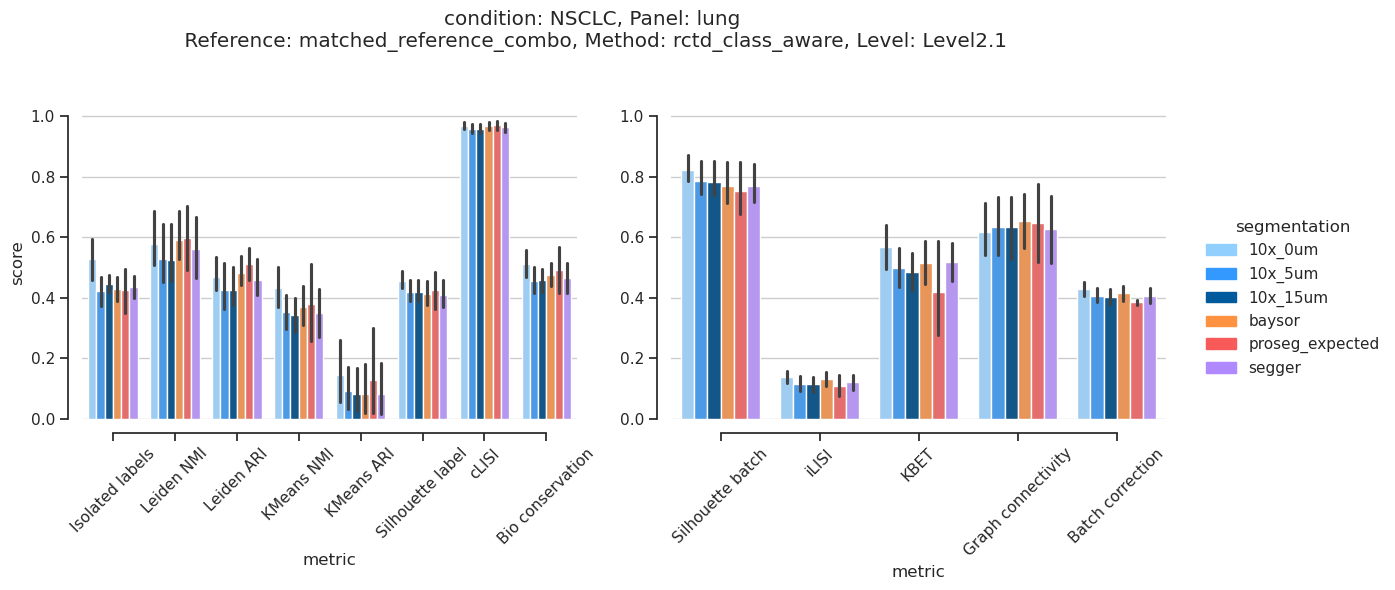

In [5]:
import matplotlib.patches as mpatches

std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'


# Set up argument parser
# Access the arguments
signal_integrity_thresholds = [0.5, 0.7]
correction_methods = ['raw', 'split_fully_purified', 'resolvi', 'resolvi_supervised']
correction_methods += [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]

condition = 'NSCLC'
panel = 'lung'
normalisation = "lognorm"  # fix this for now, even for sctransfrom args.normalisation
layer = 'data'
n_comps = 50
max_n_cells = 100_000
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'


plot_condition = condition
plot_panel = panel
palette = pd.read_csv(segmentation_palette, index_col=0).iloc[:, 0]

# variables
OBSM_KEY = "X_pca"
CT_KEY = (reference, method, level)
BATCH_KEY = "batch_key"
normalisation_annot = "lognorm"  # fix this for now, even for sctransfrom
exclude_cell_type_containing = "malignant"
xenium_levels = ["segmentation", "condition", "panel","normalisation","metric","score"]
hue = "segmentation"
hue_order = [
    "10x_mm_0um",
    "10x_mm_5um",
    "10x_mm_15um",
    "10x_0um",
    "10x_5um",
    "10x_15um",
    "baysor",
    "proseg_expected",
    "proseg_mode",
    "segger",
]


biocons_metrics = ['cLISI','Isolated labels','KMeans NMI','KMeans ARI',
                    'Leiden NMI', 'Leiden ARI','Silhouette label','Bio conservation']
batchcor_metrics = ['iLISI','Graph connectivity','KBET','Silhouette batch','Batch correction']

df = {}
for correction_method in correction_methods:
    for segmentation in (segmentations := std_seurat_analysis_dir.iterdir()):

        k = (segmentation.stem,condition,panel,normalisation)
        name = '/'.join(k)
        scib_metrics_file = results_dir / f"scib_metrics_panel/{correction_method}/{name}/scib_metrics_{layer}_{reference}_{method}_{level}_{n_comps=}_{max_n_cells=}.parquet"
        if scib_metrics_file.exists():
            df[correction_method,*k] = pd.read_parquet(scib_metrics_file).squeeze()
df = pd.concat(df).reset_index()
df.columns = ['correction_method']+xenium_levels


# plotting params, palette
title = f"condition: {plot_condition}, Panel: {plot_panel}\n Reference: {reference}, Method: {method}, Level: {level}"
unique_labels = [c for c in hue_order if c in np.unique(df[hue].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue].dropna()) if c not in unique_labels]
palette = {u: palette[u] for u in unique_labels}
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# Create joint boxplot
sns.set(style="ticks")
f, axs = plt.subplots(1,2,figsize=(12, 6),sharey=True)
g = sns.barplot(df.query("metric in @biocons_metrics"),x='metric',y='score', hue=hue, hue_order=unique_labels, legend=False, palette=palette,ax=axs[0])
g = sns.barplot(df.query("metric in @batchcor_metrics"),x='metric',y='score', hue=hue, hue_order=unique_labels, legend=False, palette=palette,ax=axs[1])

sns.despine()
axs[0].yaxis.grid(True)
axs[1].yaxis.grid(True)
axs[1].yaxis.set_tick_params(labelleft=True)
axs[0].xaxis.set_tick_params(rotation=45)
axs[1].xaxis.set_tick_params(rotation=45)

plt.suptitle(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
plt.show()

File not found: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/scib_metrics_panel/raw/proseg_mode/NSCLC/lung/lognorm/scib_metrics_data_matched_reference_combo_rctd_class_aware_Level2.1_n_comps=50_max_n_cells=100000.parquet
File not found: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/scib_metrics_panel/raw/10x_mm_5um/NSCLC/lung/lognorm/scib_metrics_data_matched_reference_combo_rctd_class_aware_Level2.1_n_comps=50_max_n_cells=100000.parquet
File not found: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/scib_metrics_panel/split_fully_purified/proseg_mode/NSCLC/lung/lognorm/scib_metrics_data_matched_reference_combo_rctd_class_aware_Level2.1_n_comps=50_max_n_cells=100000.parquet
File not found: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/scib_metrics_panel/split_fully_purified/10x_mm_5um/NSCLC/lung/lognorm/scib_metrics_data_matched_reference_combo_rctd_class_aware_Level2.1_n_comps=50_max_n_cells=100000.parquet
File not fou

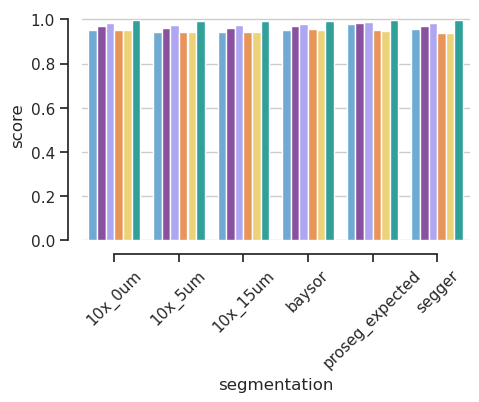

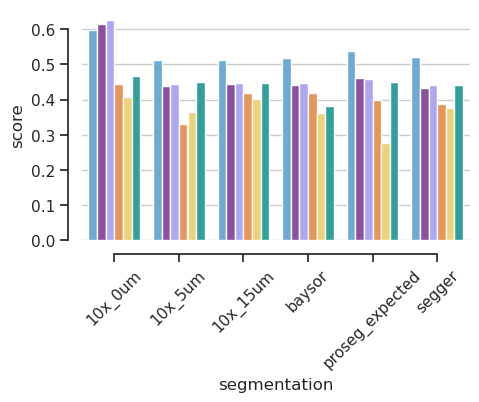

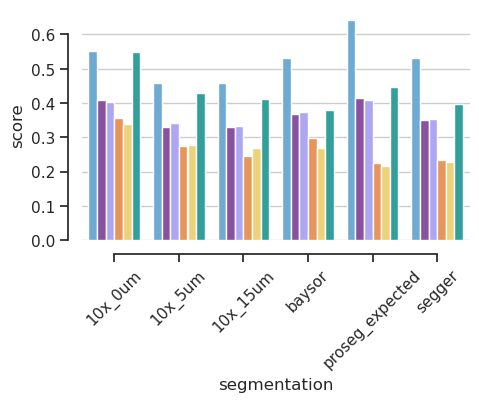

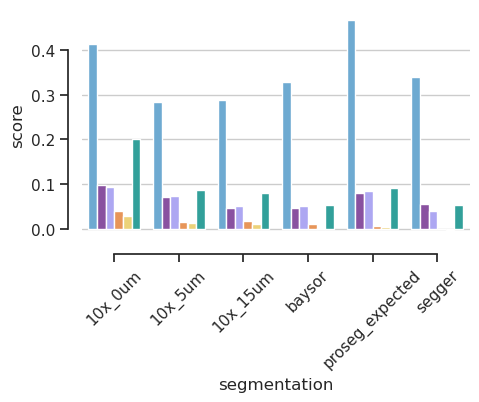

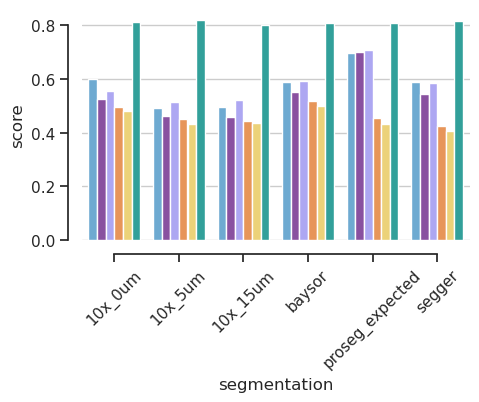

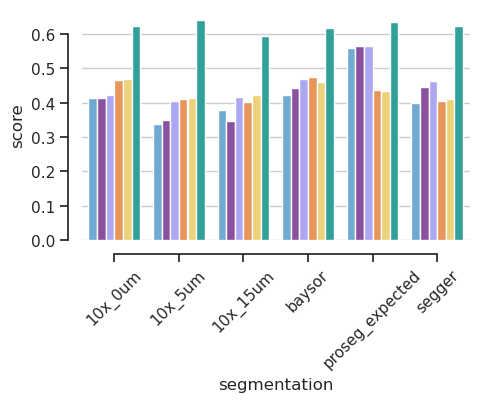

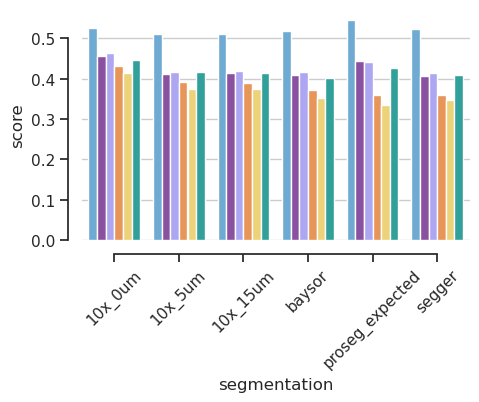

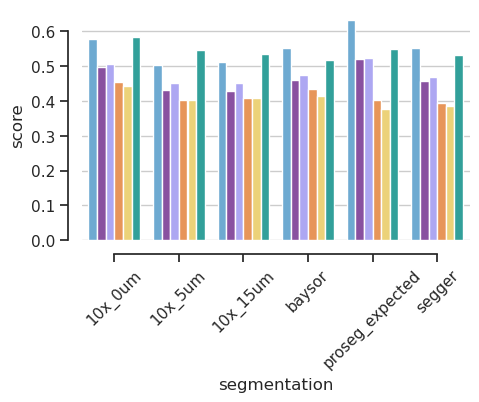

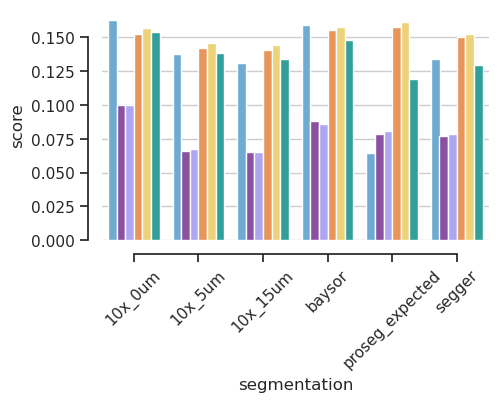

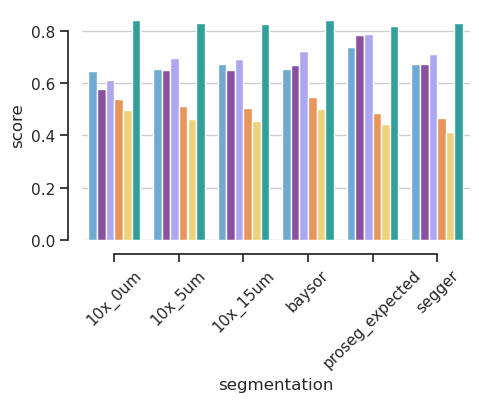

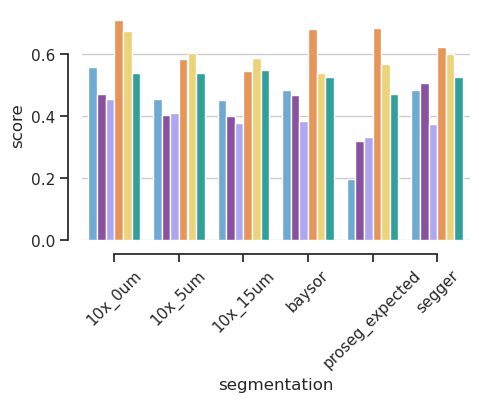

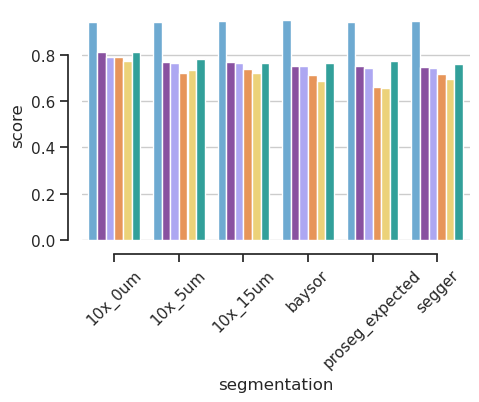

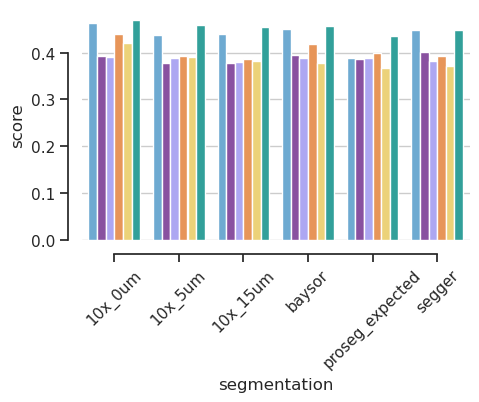

In [12]:
import matplotlib.patches as mpatches

std_seurat_analysis_dir = Path(cfg['xenium_std_seurat_analysis_dir'])
cell_type_annotation_dir = Path(cfg['xenium_cell_type_annotation_dir'])
results_dir = Path(cfg['results_dir'])
palette_dir = Path(cfg['xenium_metadata_dir'])
segmentation_palette = palette_dir / 'col_palette_segmentation.csv'
count_correction_palette = palette_dir / 'col_palette_correction_method.csv'


# Set up argument parser
# Access the arguments
signal_integrity_thresholds = [0.5, 0.7]
correction_methods = ['raw', 'split_fully_purified', 'resolvi', 'resolvi_supervised']
correction_methods += [f'ovrlpy_correction_{signal_integrity_threshold=}' for signal_integrity_threshold in signal_integrity_thresholds]

condition = 'NSCLC'
panel = 'lung'
normalisation = "lognorm"  # fix this for now, even for sctransfrom args.normalisation
layer = 'data'
n_comps = 50
max_n_cells = 100_000
reference = 'matched_reference_combo'
method = 'rctd_class_aware'
level = 'Level2.1'


plot_condition = condition
plot_panel = panel
palette = pd.read_csv(count_correction_palette)
palette = palette.set_index('correction_method').iloc[:, 0]


# variables
OBSM_KEY = "X_pca"
CT_KEY = (reference, method, level)
BATCH_KEY = "batch_key"
normalisation_annot = "lognorm"  # fix this for now, even for sctransfrom
exclude_cell_type_containing = "malignant"
xenium_levels = ["segmentation", "condition", "panel","normalisation","metric","score"]
hue_segmentation = "segmentation"
hue_segmentation_order = [
    "10x_mm_0um",
    "10x_mm_5um",
    "10x_mm_15um",
    "10x_0um",
    "10x_5um",
    "10x_15um",
    "baysor",
    "proseg_expected",
    "proseg_mode",
    "segger",
]


hue_correction = 'correction_method'
hue_correction_order = [
    'raw',
    'ResolVI',
    'ResolVI supervised',
    'ovrlpy 0.5',
    'ovrlpy 0.7',
    'SPLIT',
]


bio_score = 'Bio conservation'
batch_score = 'Batch correction'

biocons_metrics = ['cLISI','Isolated labels','KMeans NMI','KMeans ARI',
                    'Leiden NMI', 'Leiden ARI','Silhouette label','Bio conservation']
batchcor_metrics = ['iLISI','Graph connectivity','KBET','Silhouette batch','Batch correction']

df = {}
for correction_method in correction_methods:
    for segmentation in (segmentations := std_seurat_analysis_dir.iterdir()):

        k = (segmentation.stem,condition,panel,normalisation)
        name = '/'.join(k)
        scib_metrics_file = results_dir / f"scib_metrics_panel/{correction_method}/{name}/scib_metrics_{layer}_{reference}_{method}_{level}_{n_comps=}_{max_n_cells=}.parquet"
        if scib_metrics_file.exists():
            df[correction_method,*k] = pd.read_parquet(scib_metrics_file).squeeze()
        else:
            print(f"File not found: {scib_metrics_file}")
df = pd.concat(df).reset_index()
df.columns = ['correction_method']+xenium_levels
_utils.rename_methods(df)



hue = hue_correction
hue_order = hue_correction_order
u_segmentations = df['segmentation'].unique()
order = [h for h in hue_segmentation_order if h in u_segmentations]

# plotting params, palette
unique_labels = [c for c in hue_order if c in np.unique(df[hue].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue].dropna()) if c not in unique_labels]
palette = {u: palette[u] for u in unique_labels}
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

for score in biocons_metrics+batchcor_metrics:
    df_score = df.query('metric == @score')


    sns.set(style="ticks")
    # f, axs = plt.subplots(1,2,figsize=(12, 6),sharey=True)
    f = plt.figure(figsize=(5, 3))
    ax = plt.subplot()
    g = sns.barplot(df_score,x='segmentation',y='score', hue=hue_correction, hue_order=unique_labels, order=order,legend=False, palette=palette,ax=ax)
    # g = sns.barplot(df_batch_score,x='segmentation',y='score', hue=hue_correction, hue_order=unique_labels, order=order, legend=False, palette=palette,ax=axs[1])

    sns.despine()
    ax.yaxis.grid(True)
    # axs[1].yaxis.grid(True)
    # axs[1].yaxis.set_tick_params(labelleft=True)
    ax.xaxis.set_tick_params(rotation=45)
    # axs[1].xaxis.set_tick_params(rotation=45)

    # title = f"condition: {plot_condition}, Panel: {plot_panel}\n Reference: {reference}, Method: {method}, Level: {level}\n {score}"
    # plt.suptitle(title)
    # f.legend(
    #     handles=legend_handles,
    #     loc="center left",
    #     bbox_to_anchor=(1, 0.5),
    #     title=hue,
    #     frameon=False,
    # )
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(out_file, dpi=dpi, bbox_inches="tight")
    plt.show()

File not found: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/scib_metrics_panel/raw/proseg_mode/NSCLC/lung/lognorm/scib_metrics_data_matched_reference_combo_rctd_class_aware_Level2.1_n_comps=50_max_n_cells=100000.parquet
File not found: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/scib_metrics_panel/raw/10x_mm_5um/NSCLC/lung/lognorm/scib_metrics_data_matched_reference_combo_rctd_class_aware_Level2.1_n_comps=50_max_n_cells=100000.parquet
File not found: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/scib_metrics_panel/split_fully_purified/proseg_mode/NSCLC/lung/lognorm/scib_metrics_data_matched_reference_combo_rctd_class_aware_Level2.1_n_comps=50_max_n_cells=100000.parquet
File not found: /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/scib_metrics_panel/split_fully_purified/10x_mm_5um/NSCLC/lung/lognorm/scib_metrics_data_matched_reference_combo_rctd_class_aware_Level2.1_n_comps=50_max_n_cells=100000.parquet
File not fou

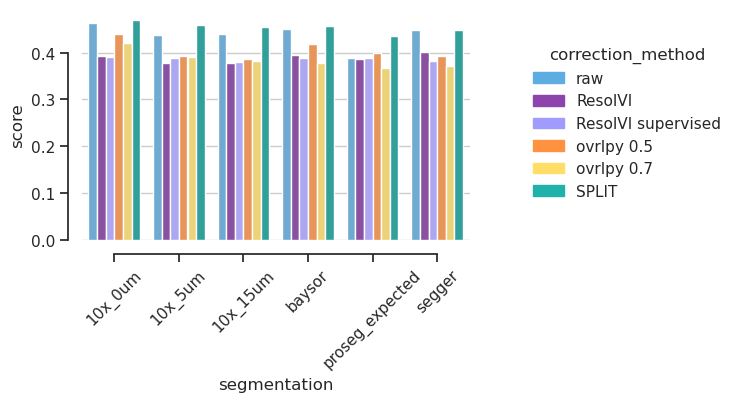

In [15]:

scib_metrics_results_dir = results_dir / "scib_metrics_panel"

# read results
df = {}
for correction_method in correction_methods:
    for segmentation in (segmentations := std_seurat_analysis_dir.iterdir()):
        k = (segmentation.stem, condition, panel, normalisation)
        name = "/".join(k)
        scib_metrics_file = (
            scib_metrics_results_dir
            / f"{correction_method}/{name}/scib_metrics_{layer}_{reference}_{method}_{level}_{n_comps=}_{max_n_cells=}.parquet"
        )
        if scib_metrics_file.exists():
            df[correction_method, *k] = pd.read_parquet(scib_metrics_file).squeeze()
        else:
            print(f"File not found: {scib_metrics_file}")
df = pd.concat(df).reset_index()
df.columns = ["correction_method"] + xenium_levels
_utils.rename_methods(df)


u_segmentations = df["segmentation"].unique()
order = [h for h in hue_segmentation_order if h in u_segmentations]

# plotting params, palette
unique_labels = [c for c in hue_correction_order if c in np.unique(df[hue_correction].dropna())]
unique_labels = unique_labels + [c for c in np.unique(df[hue_correction].dropna()) if c not in unique_labels]
palette = {u: palette[u] for u in unique_labels}
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]

# for score in biocons_metrics + batchcor_metrics:
df_score = df.query("metric == @score")

sns.set(style="ticks")
f = plt.figure(figsize=(5, 3))
ax = plt.subplot()
g = sns.barplot(
    df_score,
    x="segmentation",
    y="score",
    hue=hue_correction,
    hue_order=unique_labels,
    order=order,
    legend=False,
    palette=palette,
    ax=ax,
)

sns.despine()
ax.yaxis.grid(True)
ax.xaxis.set_tick_params(rotation=45)

f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)